# Clasificación binaria usando distintos modelos

En esta práctica se contruyen distintos modelos de clasificación binaria para predecri si a un cliente se le autoriza un préstamo en base a sus características.

Se entrenarán 6 modelos distintos y al final seleccionaremos el que ofrezca un mejor desempeño.

En el desarrollo se aplicarán las siguientes transformaciones:
* Normalización y estandarización de datos
* Tratamiento de registros nulos
* Codificación de datos categóricos
* Tratamiento de outliers
* Particionamiento de datos para entrenamiento y pruebas
* Predicción y evaluación de modelos usando distintas métricas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from scipy import stats

#!pip install scikit-learn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Support Vector Machines
from sklearn.svm import LinearSVC

# Decision Trees
from sklearn.tree import DecisionTreeClassifier

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Naive Bayes
from sklearn.naive_bayes import GaussianNB

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

## Cargamos datos

In [2]:
df = pd.read_csv("data/Loan_Data.csv")
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
df = df.drop(['Loan_ID'], axis=1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


### Eliminamos registros con campos vacíos

In [5]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 480 entries, 1 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             480 non-null    object 
 1   Married            480 non-null    object 
 2   Dependents         480 non-null    object 
 3   Education          480 non-null    object 
 4   Self_Employed      480 non-null    object 
 5   ApplicantIncome    480 non-null    int64  
 6   CoapplicantIncome  480 non-null    float64
 7   LoanAmount         480 non-null    float64
 8   Loan_Amount_Term   480 non-null    float64
 9   Credit_History     480 non-null    float64
 10  Property_Area      480 non-null    object 
 11  Loan_Status        480 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 48.8+ KB


### Identificamos los tipos de columnas

In [6]:
# Extraemos las columnas numéricas
cols_num = df.select_dtypes(include='number').columns
cols_num

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')

In [7]:
# Numero de columnas numéricas:
n = len(cols_num)
n

5

In [8]:
# Extraemos las columnas no numéricas
cols_obj = df.select_dtypes(include='object').columns
cols_obj

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area', 'Loan_Status'],
      dtype='object')

## Detección y tratamiento de Outliers

In [9]:
# Usamos 'zscore' para obtener los múltiplos de desviación estándar a la que distan los
# datos con respecto a la media:

l_out = 4.5 # radio de outliers (Entre más pequeño quita más datos)

idx_out = {}

for cn in cols_num:

    # Extraemos el Z-score de la columna "cn" 
    z=np.abs(stats.zscore(df[cn])) 

    # Guardamos los índices en donde se encuentran los outliers (aquellos valores tales que 'z > l_out')
    idx_out[cn] = df[cn][ z > l_out ].index

    print(f'Se detectaron {len( idx_out[cn] )} outliers en el campo {cn}')


Se detectaron 5 outliers en el campo ApplicantIncome
Se detectaron 3 outliers en el campo CoapplicantIncome
Se detectaron 3 outliers en el campo LoanAmount
Se detectaron 2 outliers en el campo Loan_Amount_Term
Se detectaron 0 outliers en el campo Credit_History


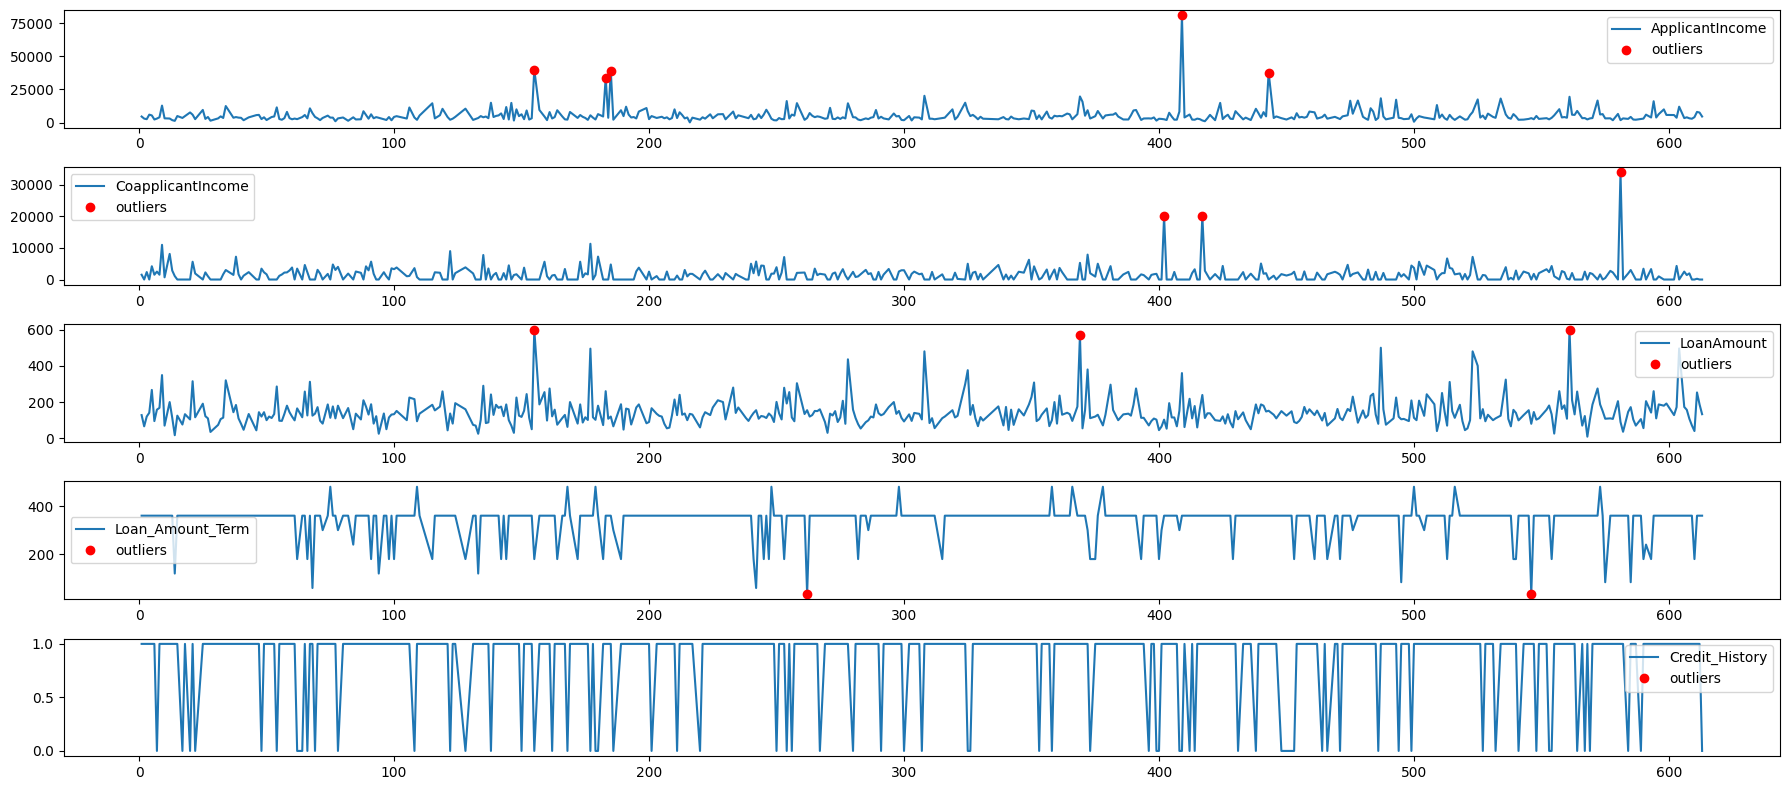

In [10]:
plt.figure(figsize=(18,8))
i=0
for cn in cols_num:
    plt.subplot(n,1,i+1)
    plt.plot(df[cn] , label = cn)
    plt.plot(df[cn].loc[idx_out[cn]],'o',c='r', label = 'outliers')
    plt.legend()
    i = i+1

plt.tight_layout()
plt.show()

### Eliminamos outliers

In [11]:
# índices de los outliers detactados en cada columna numérica:
idx_out

{'ApplicantIncome': Index([155, 183, 185, 409, 443], dtype='int64'),
 'CoapplicantIncome': Index([402, 417, 581], dtype='int64'),
 'LoanAmount': Index([155, 369, 561], dtype='int64'),
 'Loan_Amount_Term': Index([262, 546], dtype='int64'),
 'Credit_History': Index([], dtype='int64')}

In [12]:
# índices de los outliers detactados en cada columna numérica:
all_idx_out = [ idx_out[cn] for cn in cols_num ]
all_idx_out

[Index([155, 183, 185, 409, 443], dtype='int64'),
 Index([402, 417, 581], dtype='int64'),
 Index([155, 369, 561], dtype='int64'),
 Index([262, 546], dtype='int64'),
 Index([], dtype='int64')]

In [13]:
# Colocamos en un "set" todos los índices y en automático se eliminarán valores (índices) repetidos:
unique_idx_out = {x for l in all_idx_out for x in l}
unique_idx_out

{155, 183, 185, 262, 369, 402, 409, 417, 443, 546, 561, 581}

In [14]:
df.shape

(480, 12)

In [15]:
# Eliminamos renglones con outliers
df = df.drop(unique_idx_out, axis=0)
print(f'Se eliminaron {len(unique_idx_out)} renglones')

Se eliminaron 12 renglones


In [16]:
df.shape

(468, 12)

## Convertimos campos no númericos a categóricos

<img src="images\f0.png" width="700" height="300">


In [17]:
df_dummy = pd.get_dummies(df, dtype=int)
df_dummy.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,...,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_N,Loan_Status_Y
1,4583,1508.0,128.0,360.0,1.0,0,1,0,1,0,...,0,1,0,1,0,1,0,0,1,0
2,3000,0.0,66.0,360.0,1.0,0,1,0,1,1,...,0,1,0,0,1,0,0,1,0,1
3,2583,2358.0,120.0,360.0,1.0,0,1,0,1,1,...,0,0,1,1,0,0,0,1,0,1
4,6000,0.0,141.0,360.0,1.0,0,1,1,0,1,...,0,1,0,1,0,0,0,1,0,1
5,5417,4196.0,267.0,360.0,1.0,0,1,0,1,0,...,0,1,0,0,1,0,0,1,0,1


In [18]:
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 468 entries, 1 to 613
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ApplicantIncome          468 non-null    int64  
 1   CoapplicantIncome        468 non-null    float64
 2   LoanAmount               468 non-null    float64
 3   Loan_Amount_Term         468 non-null    float64
 4   Credit_History           468 non-null    float64
 5   Gender_Female            468 non-null    int32  
 6   Gender_Male              468 non-null    int32  
 7   Married_No               468 non-null    int32  
 8   Married_Yes              468 non-null    int32  
 9   Dependents_0             468 non-null    int32  
 10  Dependents_1             468 non-null    int32  
 11  Dependents_2             468 non-null    int32  
 12  Dependents_3+            468 non-null    int32  
 13  Education_Graduate       468 non-null    int32  
 14  Education_Not Graduate   468 no

## Normalización de campos numéricos
Por cuestiones de experimentación usaremos 2 transformaciones de normalización.

In [19]:
# Hacemos una copias del dataframe:
df_norm_MinMax = df_dummy.copy()
df_norm_Std = df_dummy.copy()

In [20]:
# Declaramos las transformaciones de escala:
scaler_MinMax = MinMaxScaler()
scaler_Std = StandardScaler()

### Transformación 1: `MinMaxScaler`
Transforma los campos numéricos a una escala entre 0 y 1

In [21]:
# Aplicamos transfromación 1:
df_norm_MinMax[cols_num] = scaler_MinMax.fit_transform(df_norm_MinMax[cols_num])
df_norm_MinMax.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,...,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_N,Loan_Status_Y
1,0.220734,0.133451,0.242363,0.714286,1.0,0,1,0,1,0,...,0,1,0,1,0,1,0,0,1,0
2,0.141911,0.000000,0.116090,0.714286,1.0,0,1,0,1,1,...,0,1,0,0,1,0,0,1,0,1
3,0.121147,0.208673,0.226069,0.714286,1.0,0,1,0,1,1,...,0,0,1,1,0,0,0,1,0,1
4,0.291291,0.000000,0.268839,0.714286,1.0,0,1,1,0,1,...,0,1,0,1,0,0,0,1,0,1
5,0.262262,0.371327,0.525458,0.714286,1.0,0,1,0,1,0,...,0,1,0,0,1,0,0,1,0,1


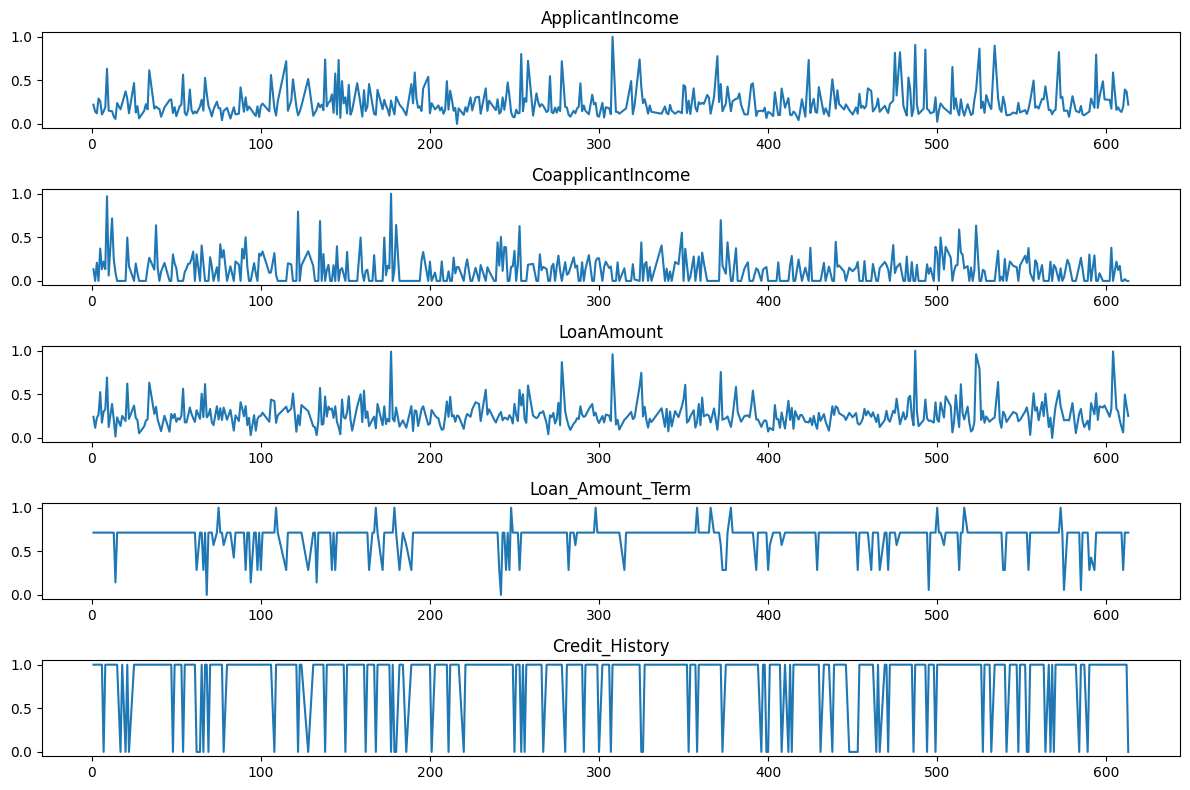

In [22]:
plt.figure( figsize=(12,8) )
i=0
for cn in cols_num:
    plt.subplot(n,1,i+1)
    df_norm_MinMax[ cn ].plot( title=cn )
    i=i+1

plt.tight_layout()

#### Aplicamos transformación inversa para recuperar los datos en la escala original:

In [23]:
df_norm_MinMax[cols_num] = scaler_MinMax.inverse_transform(df_norm_MinMax[cols_num])
df_norm_MinMax.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,...,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_N,Loan_Status_Y
1,4583.0,1508.0,128.0,360.0,1.0,0,1,0,1,0,...,0,1,0,1,0,1,0,0,1,0
2,3000.0,0.0,66.0,360.0,1.0,0,1,0,1,1,...,0,1,0,0,1,0,0,1,0,1
3,2583.0,2358.0,120.0,360.0,1.0,0,1,0,1,1,...,0,0,1,1,0,0,0,1,0,1
4,6000.0,0.0,141.0,360.0,1.0,0,1,1,0,1,...,0,1,0,1,0,0,0,1,0,1
5,5417.0,4196.0,267.0,360.0,1.0,0,1,0,1,0,...,0,1,0,0,1,0,0,1,0,1


In [24]:
# Datos originales:
df_dummy.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,...,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_N,Loan_Status_Y
1,4583,1508.0,128.0,360.0,1.0,0,1,0,1,0,...,0,1,0,1,0,1,0,0,1,0
2,3000,0.0,66.0,360.0,1.0,0,1,0,1,1,...,0,1,0,0,1,0,0,1,0,1
3,2583,2358.0,120.0,360.0,1.0,0,1,0,1,1,...,0,0,1,1,0,0,0,1,0,1
4,6000,0.0,141.0,360.0,1.0,0,1,1,0,1,...,0,1,0,1,0,0,0,1,0,1
5,5417,4196.0,267.0,360.0,1.0,0,1,0,1,0,...,0,1,0,0,1,0,0,1,0,1


### Transformación 2: `StandardScaler`
Transforma los campos numéricos a una escala tal que la media es 0 y la desviación estándar es 1

In [25]:
# Aplicamos transformación 2:
df_norm_Std[cols_num] = scaler_Std.fit_transform(df_norm_Std[cols_num])
df_norm_Std.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,...,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_N,Loan_Status_Y
1,-0.096413,0.036448,-0.185202,0.26687,0.412311,0,1,0,1,0,...,0,1,0,1,0,1,0,0,1,0
2,-0.584676,-0.802196,-1.046393,0.26687,0.412311,0,1,0,1,1,...,0,1,0,0,1,0,0,1,0,1
3,-0.713297,0.509159,-0.296324,0.26687,0.412311,0,1,0,1,1,...,0,0,1,1,0,0,0,1,0,1
4,0.340650,-0.802196,-0.004630,0.26687,0.412311,0,1,1,0,1,...,0,1,0,1,0,0,0,1,0,1
5,0.160828,1.531326,1.745532,0.26687,0.412311,0,1,0,1,0,...,0,1,0,0,1,0,0,1,0,1


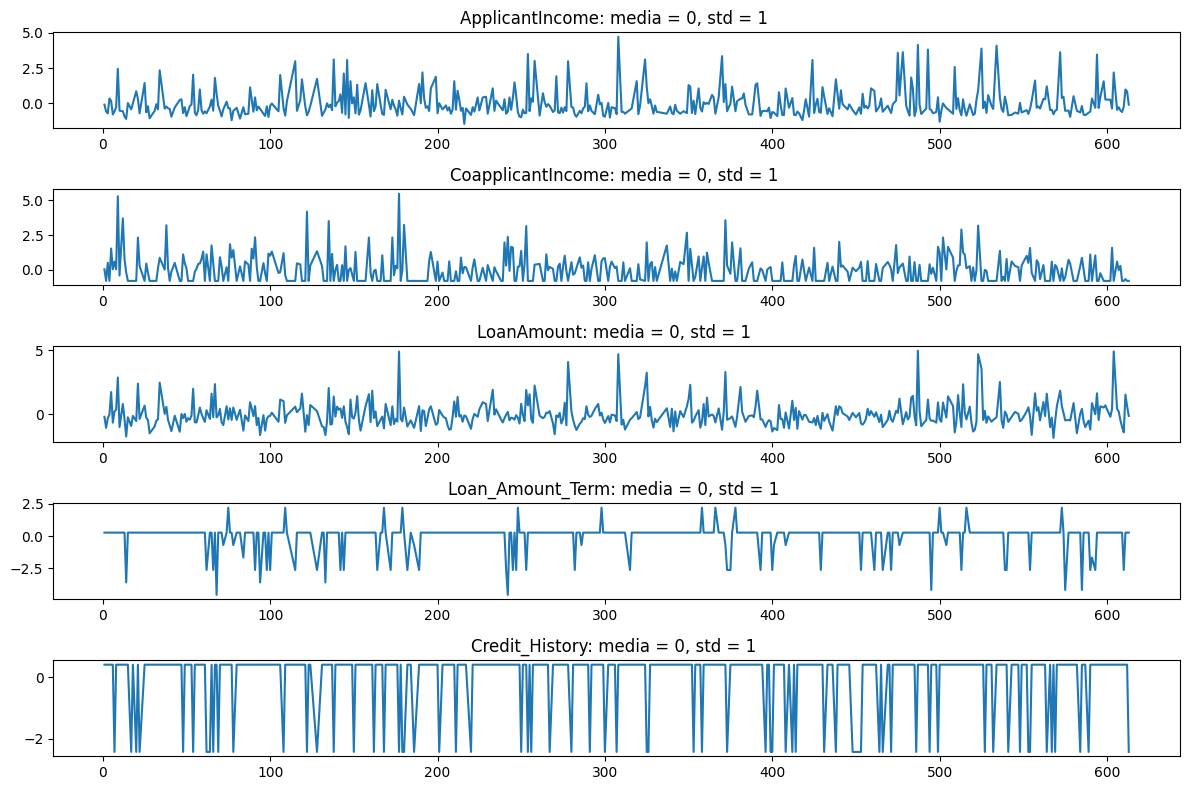

In [26]:
plt.figure( figsize=(12,8) )
i=0
for cn in cols_num:
    plt.subplot(n,1,i+1)
    mu = round(df_norm_Std[ cn ].mean())
    d_std = round(df_norm_Std[ cn ].std())
    df_norm_Std[ cn ].plot( title=f'{cn}: media = {mu}, std = {d_std} ')
    i=i+1

plt.tight_layout()

#### Aplicamos transformación inversa para recuperar los datos en la escala original:

In [27]:
df_norm_Std[cols_num] = scaler_Std.inverse_transform(df_norm_Std[cols_num])
df_norm_Std.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,...,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_N,Loan_Status_Y
1,4583.0,1508.0,128.0,360.0,1.0,0,1,0,1,0,...,0,1,0,1,0,1,0,0,1,0
2,3000.0,0.0,66.0,360.0,1.0,0,1,0,1,1,...,0,1,0,0,1,0,0,1,0,1
3,2583.0,2358.0,120.0,360.0,1.0,0,1,0,1,1,...,0,0,1,1,0,0,0,1,0,1
4,6000.0,0.0,141.0,360.0,1.0,0,1,1,0,1,...,0,1,0,1,0,0,0,1,0,1
5,5417.0,4196.0,267.0,360.0,1.0,0,1,0,1,0,...,0,1,0,0,1,0,0,1,0,1


In [28]:
# Datos originales:
df_dummy.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,...,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_N,Loan_Status_Y
1,4583,1508.0,128.0,360.0,1.0,0,1,0,1,0,...,0,1,0,1,0,1,0,0,1,0
2,3000,0.0,66.0,360.0,1.0,0,1,0,1,1,...,0,1,0,0,1,0,0,1,0,1
3,2583,2358.0,120.0,360.0,1.0,0,1,0,1,1,...,0,0,1,1,0,0,0,1,0,1
4,6000,0.0,141.0,360.0,1.0,0,1,1,0,1,...,0,1,0,1,0,0,0,1,0,1
5,5417,4196.0,267.0,360.0,1.0,0,1,0,1,0,...,0,1,0,0,1,0,0,1,0,1


## Seleccionamos los campos de features y labels

In [29]:
# Seleccionamos un dataframe normalizado:

#df_ml = df_norm_MinMax.copy()
df_ml = df_norm_Std.copy()

In [30]:
# Extraemos las columnas de Features:
cols_features = df_ml.columns[0:-2]
cols_features

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Gender_Female', 'Gender_Male',
       'Married_No', 'Married_Yes', 'Dependents_0', 'Dependents_1',
       'Dependents_2', 'Dependents_3+', 'Education_Graduate',
       'Education_Not Graduate', 'Self_Employed_No', 'Self_Employed_Yes',
       'Property_Area_Rural', 'Property_Area_Semiurban',
       'Property_Area_Urban'],
      dtype='object')

In [31]:
# Extraemos la columna de Labels:
cols_labels = df_ml.columns[-1:]
cols_labels

Index(['Loan_Status_Y'], dtype='object')

In [32]:
X = df_ml[cols_features].values
Y = df_ml[cols_labels].values

In [33]:
X.shape

(468, 20)

In [34]:
Y.shape

(468, 1)

In [35]:
# Redimensionamos el label como un vector de dimensión 1:
Y = Y.reshape( Y.shape[0], )
Y.shape

(468,)

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    train_size=0.7,
                                                    random_state=1234,
                                                    stratify=Y
                                                    )

In [37]:
X_train.shape

(327, 20)

In [38]:
Y_train.shape

(327,)

In [39]:
X_test.shape

(141, 20)

In [40]:
Y_test.shape

(141,)

## Construcción de modelos

In [41]:
# Creamos un diccionario para ir guardando los modelos
models = {}

# Logistic Regression
models['Logistic Regression'] = LogisticRegression(solver='lbfgs', tol=0.00001, max_iter=500, random_state=123)

# Support Vector Machines
models['Support Vector Machines'] = LinearSVC(max_iter=5000, random_state=123)

# Decision Trees
models['Decision Trees'] = DecisionTreeClassifier(max_depth=3, random_state=123)

# Random Forest
models['Random Forest'] = RandomForestClassifier(max_depth=3, max_samples=100, random_state=123)

# Naive Bayes
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
models['K-Nearest Neighbor'] = KNeighborsClassifier()

models

{'Logistic Regression': LogisticRegression(max_iter=500, random_state=123, tol=1e-05),
 'Support Vector Machines': LinearSVC(max_iter=5000, random_state=123),
 'Decision Trees': DecisionTreeClassifier(max_depth=3, random_state=123),
 'Random Forest': RandomForestClassifier(max_depth=3, max_samples=100, random_state=123),
 'Naive Bayes': GaussianNB(),
 'K-Nearest Neighbor': KNeighborsClassifier()}

### Entrenamos los modelos

In [42]:
accuracy, precision, recall = {}, {}, {}

for k in models.keys():
    print(f'Entrenando el modelo: {k}')
    
    # Fit the classifier
    models[k].fit(X_train, Y_train)
    
    # Make predictions
    predictions = models[k].predict(X_test)
    
    # Calculate metrics
    accuracy[k] = accuracy_score(predictions, Y_test)
    precision[k] = precision_score(predictions, Y_test)
    recall[k] = recall_score(predictions, Y_test)

Entrenando el modelo: Logistic Regression
Entrenando el modelo: Support Vector Machines
Entrenando el modelo: Decision Trees
Entrenando el modelo: Random Forest
Entrenando el modelo: Naive Bayes
Entrenando el modelo: K-Nearest Neighbor


c:\Users\Marcos KodeFree\Desktop\Entornos_Python\env_ML\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [43]:
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

df_model

,Accuracy,Precision,Recall
Logistic Regression,0.822695,0.989899,0.803279
Support Vector Machines,0.702128,1.000000,0.702128
Decision Trees,0.808511,0.959596,0.805085
Random Forest,0.822695,0.989899,0.803279
Naive Bayes,0.773050,0.898990,0.801802
K-Nearest Neighbor,0.680851,0.919192,0.710938


### Seleccionamos el modelo con mejor Accuracy

In [44]:
max_acc = df_model['Accuracy'].max()
max_acc

0.8226950354609929

In [45]:
best_model = df_model[ df_model['Accuracy']==max_acc ].index[0]
best_model

'Logistic Regression'

### Predecimos datos de prueba

In [46]:
Y_pred = models[best_model].predict( X_test )

Y_pred.shape

(141,)

In [47]:
# Calculamos score de probabilidades
Y_prob = models[best_model].predict_proba( X_test )[:,1]
Y_prob.shape

(141,)

## Calculamos el accuracy y la matriz de confusión

In [48]:
# Matriz de confusión:
cm = confusion_matrix(Y_test , Y_pred)
cm

array([[18, 24],
       [ 1, 98]], dtype=int64)

In [49]:
# Accuracy:
acc = np.trace(cm) /sum(sum(cm))
acc

0.8226950354609929

In [50]:
score = models[best_model].score(X_test, Y_test)
score

0.8226950354609929